In [3]:
import pandas as pd 
import numpy as np
import scipy.stats as ss

import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
import itertools
from pprint import pprint

# set some styling defaults for matplotlib
plt.style.use("seaborn-talk")
mpl.rcParams["figure.dpi"] = 90  # change this to set apparent figure size
mpl.rcParams["figure.figsize"] = (10, 4)
mpl.rcParams["figure.frameon"] = False

# set decimal precision to 3 dec. places
%precision 3

import sys
sys.path += ["practical_exercise", "examples"]

from temperature import create_game_ui
from skopt.learning.gaussian_process import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import RBF
import scipy.stats
from gp_utils import render_gp, ei, pi, lcb, ucb, plot_gp_samples

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# IV: Practical task: Bayesian product design

https://app.sli.do/event/rDUA5XYTvm9RmYtLHAQit9

## What's the goal?

### A Bayesian food thermometer

<img src="imgs/grill.jpg" width="70%">

**[Image by Ahmed Ardity: https://pixabay.com/photos/food-temperature-safety-hot-cook-5053725/]**

We'll explore how Bayesian ideas could be used in product design for everyday devices. We'll build a **Bayesian meat thermometer** (or food thermometer, if you are vegetarian).

Meat thermometers are essential tools in correctly cooking meats and fish (they're also essential for making candy). They are especially useful with unpredictable heating sources like barbecues. It's dangerous to eat undercooked food, and some foods (like shellfish) become unpleasant rapidly if overcooked. Chefs use thermometers to ensure their food is safe and tasty.

### The problem

<img src="imgs/thermometer_meat.png" width="65%">

What we want to know is how well cooked the food is (the hidden state). What we observe is a digitised voltage from a temperature sensor. Unfortunately, we bought cheap temperature sensors, which are slow to react and quite noisy. Standard thermometers just display a calibrated version of the sensor voltage on an LCD: the raw sensor value. 

Problems:

* It takes quite some time for the temperature reading to stabilise
* The readings aren't accurate (mis-calibration) or precise (noise).

> Caveat: We don't really need a Bayesian meat thermometer -- careful use of a standard thermometer works just fine. But we'll explore how Bayesian representations could be used in a product like this.

<img src="imgs/temperature_problem.png" width="95%">

## How should you approach this?

* Work in teams
* There's a skeleton *non-Bayesian* meat thermometer working and implemented
* There are helper functions that can be plugged in to add Bayesian super powers

### Thermometer simulator

### Controls and task
#### Task
Cook the food. You'll be told the temperature to cook to, and the oven temperature. A basic display will show you the theremometer temperature below. It updates once per second.

#### Controls
You have the following controls:

<img src="imgs/cooking.png">
          
* **Cook 30, 10, 5, 1**: cook the food for another 30, 10, 5 or 1 minutes
* **Serve food!**: take the food and out and serve it

The display updates continuously.

### Cookedness
<img src="imgs/chicken_curve.png">

### Metrics
The metric is the best cooked food with the least time spent looking at the display. The cookedness will automatically be computed for you. You'll get a single overall score that combines time and cookedness.

## Procedure
### I: Establishing a baseline

The thermometer has a parameter *k* which determines how noisy and how responsive the thermometer is. 

* Low k means slow response, but low noise
* High k means a fast response, but higher noise

Using k=5.5:
* cook five dishes (each) to warm up
* **then** cook five dishes and *record your scores for those five*.  

Note: dishes are not always the same!

In [3]:
create_game_ui(k=5.5)

In [4]:
base_line_scores = [] # record your scores (after warmup) here

## Part I: [Bayesian] optimising the sensor
One parameter we can adjust is `k`, which trades off precision for time to acquire the temperature accurately.

Use Bayesian optimisation to optimise the thermometer's k parameter. Play the cooking game again, starting with `k=5.5` as before, but after each game, compute a new `k` to test using `show_gp_optimiser`. 

* Think of strategies to optimise *as a team*; for example, play five simulatenous games with the same k after each optimiser step, and pass all the results to the next step.
* Remember that `k` is very indirectly tied to the scores you get; a really bad `k` will make it hard, but there are lots of other factors as well.

You can adjust both the implied *smoothness* of the proxy objective function and the expected *noise level* in the measurements. As the code is written, it is assumed that noise is zero, which isn't a good model of something as noisy as playing this game.

In [ ]:
def show_gp_optimiser(ks, scores, smooth=5.0, noise=0.0):
    scores = np.array(scores)/100
    gp = GaussianProcessRegressor(kernel=RBF(smooth, "fixed"), alpha=noise)
    if len(ks)>0:
        ks = np.array(ks).reshape(-1,1)
        gp.fit(ks, scores)
    # show the GP
    fig, ax = plt.subplots(nrows=2, figsize=(12, 6))
    k_curve = np.linspace(0, 15, 100)
    render_gp(ax[0], k_curve, gp)
    # compute the curve at a series of points
    score_pred, score_std = gp.predict(k_curve[:,None], return_std=True)
    
    # show the data
    if len(ks)>0:
        ax[0].scatter(ks, scores)
        ax[0].scatter([ks[-1]], [scores[-1]], c='C2')
    # compute the upper confidence bound
    ucb_improvement = ucb(score_pred, score_std, kappa=5)
    ax[1].plot(ucb_improvement, c='k')
    ax[1].set_ylabel("UCB")
    # return the next point to try
    return k_curve[np.argmax(ucb_improvement)]

3.333

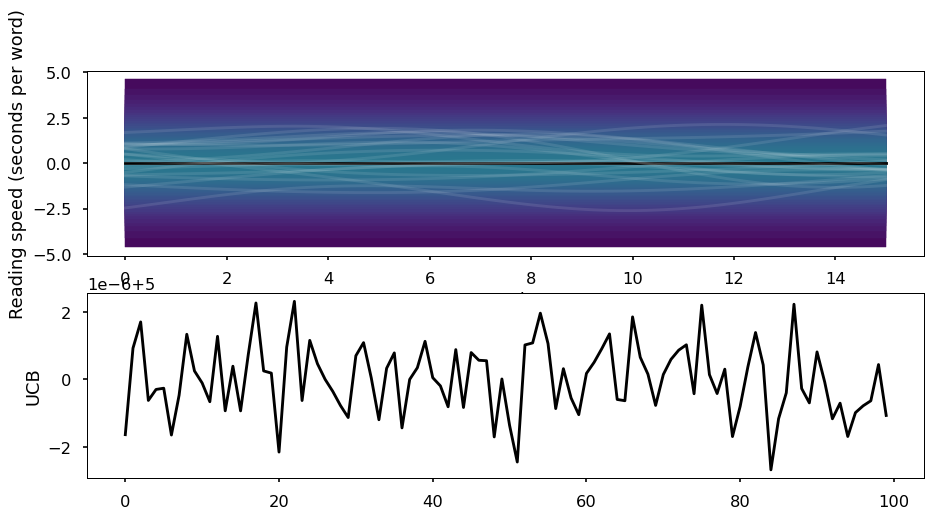

In [34]:
# put in the scores you got for each k here. For example,
# if you played three games at k=5.5 and got 103, 34, 504 
# and then played one game at k=8 and got 30, then you'd write
#
# show_gp_optimiser(ks=[5.5, 5.5, 5.5, 8], scores=[103, 34, 504, 8]) 
#
show_gp_optimiser(ks=[], scores=[])